In [ ]:
import Pkg
Pkg.add("Turing")
Pkg.add("Flux")
Pkg.add("NCDatasets")
Pkg.add("TSVD")
Pkg.add("Statistics")
Pkg.add("Compat")
Pkg.add("LinearAlgebra")
Pkg.add("Glob")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Distributions")
Pkg.add("ProgressMeter")
Pkg.add("PyPlot")
Pkg.add("Random")
Pkg.add("StatsPlots")
Pkg.add("SpecialFunctions")
Pkg.add("ReverseDiff")
Pkg.add("BSON")
Pkg.add("TransformVariables")
Pkg.add("TransformedLogDensities")
Pkg.add("LogDensityProblems")
Pkg.add("LogDensityProblemsAD")
Pkg.add("DynamicHMC")
Pkg.add("Parameters")
Pkg.add("TSVD")
Pkg.add("Glob")

In [1]:
using Flux
using Statistics
using LinearAlgebra
using Compat
using Glob
using TSVD
using NCDatasets
using CSV
using DataFrames
using Distributions: Categorical, Dirichlet, Gamma, Beta
using ProgressMeter
using PyPlot
using Random
using SpecialFunctions: loggamma
using ReverseDiff
using BSON: @load

In [2]:
obs_file ="../data/observed_speeds/greenland_vel_mosaic250_v1_g9000m.nc"
d_obs = NCDataset(obs_file)
v_obs = d_obs["velsurf_mag"][:]
v_obs = nomissing(v_obs, 0.0);
idx = findall(v_obs .> 0)
Obs = v_obs[idx];

n_grid_points = size(idx)[1];

In [3]:
training_files = sort(glob("../tests/training_data/*.nc"))

nf = length(training_files)
d = NCDataset(training_files[1], "r")
v = d["velsurf_mag"]
nx, ny, nt = size(v)

Data = zeros(n_grid_points, nf * nt)
ids = zeros(Int64, nf)
@showprogress for (k, training_file) in enumerate(training_files)
    m_id = match(r"id_(.+?)_", training_file)
    ids[k] = parse(Int, m_id[1])
    d = NCDataset(training_file, "r")
    v = d["velsurf_mag"][:]
    v = nomissing(v, 0.0)
    Data[:, k] = v[idx]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


## Read training samples

In [4]:
X_df = DataFrame(CSV.File("../data/samples/velocity_calibration_samples_50.csv"))
X_df = X_df[ [x in ids for x in X_df[!, :id]] ,:]
X = transpose(Matrix(X_df[!, 2:9]))
X_mean = mean(X, dims=2);
X_std = std(X, dims=2);
X_scaled = (X .- X_mean) ./ X_std;
X_train = X_scaled;
n_parameters, n_samples = size(X);

## Load the model

Should be a commmand line argument

That we have to define the struct again is not ok. How can we avoid this?

In [5]:
struct NNModel
    chain::Chain
    V_hat::AbstractArray
    F_mean::AbstractArray
end

function (m::NNModel)(x, add_mean=false)
    if add_mean
        return V_hat * m.chain(x) .+ F_mean
    else
        return V_hat * m.chain(x)
    end

end

In [107]:
@load "emulator_1.bson" model
# model = Flux.loadmodel!(model, @load("mymodel.bson"))

In [7]:
function get_eigenglaciers(omegas, F, q)
    
    F_mean = sum(F .* omegas, dims=2);
    F_bar = F .- F_mean;

    Z = diagm(sqrt.(omegas[1, :] * n_grid_points))
    U, S, V = tsvd(Z * transpose(F_bar), q);
    lamda = S.^2 / n_grid_points
    V_hat = V * diagm(sqrt.(lamda));
    
    return V_hat, F_bar, F_mean
end;

In [46]:
q = 50
F = log10.(Data)
F = replace!(F, -Inf=>0)

dirichlet_dist = Dirichlet(n_samples, 1)

model_index = 1
Random.seed!(model_index)
omegas = transpose(rand(dirichlet_dist, 1))
omegas_0 = omegas ./ size(omegas)[1];
    
V_hat, F_bar, F_mean = get_eigenglaciers(omegas, F, q);

In [47]:
alpha_b = 3;
beta_b = 3;
beta_dist = Beta(alpha_b, beta_b);
X_prior = rand(beta_dist, n_parameters, 100000);
X_0 = mean(X_prior, dims=2);

In [48]:
Y_target = log10.(Obs);
Y_target = replace!(Y_target, -Inf=>0);

In [49]:
grid_resolution = ones(n_grid_points) .* 9000
sigma = 10
rho = 1.0 / (1e4 .^ 2)
point_area = (grid_resolution) .^ 2
K = point_area .* rho
sigma_hat = sqrt.(sigma .^ 2 ./ K .^ 2)

X_min = minimum(X_scaled, dims=2);
X_max = maximum(X_scaled, dims=2);

In [50]:
using TransformVariables, TransformedLogDensities, LogDensityProblems, LogDensityProblemsAD,
    DynamicHMC, DynamicHMC.Diagnostics, Parameters, Statistics, Random

In [100]:
struct SampleBayesProblem
    nn
    X_min::AbstractArray
    X_max::AbstractArray
    Y_target::AbstractArray
    sigma_hat::AbstractArray
    nu::Int
    alpha::Float16
end

In [101]:
function (problem::SampleBayesProblem)(θ)
    @unpack α = θ               # extract the parameters
    @unpack nn, X_min, X_max, Y_target, sigma_hat, nu, alpha = problem       # extract the data
    
    Y_pred = 10 .^ nn(α, true)
    r = Y_pred .- Y_target
    t = r ./ sigma_hat

    # StudentT distribution
    loglikelihood = sum(
        loggamma((nu + 1) / 2)
        - loggamma(nu / 2)
        .- log.(sqrt.(pi * nu) .* sigma_hat)
        .- (nu + 1) / 2.0 * log.(1 .+ 1.0 / nu .* t .^ 2)
    )
    # Beta prior
    X_bar = relu((α .- X_min) ./ (X_max - X_min))
    logprior = sum(
        (alpha_b - 1) * log.(X_bar) + (beta_b - 1) * log.(1 .- X_bar) 
        .+ loggamma(alpha_b + beta_b) 
        .- loggamma(alpha_b)
        .- loggamma(beta_b)
    )
    return (alpha * loglikelihood + logprior)
end

In [102]:
nu = 1
alpha = 0.01


0.01

In [108]:
logp = SampleBayesProblem(model, X_min, X_max, Y_target, sigma_hat, nu, alpha)
logp((α = X_0,)) # make sure that it works

-1452.0127961516039

In [109]:
trans = as((α = as(Array, as𝕀, n_parameters),))
P = TransformedLogDensity(trans, logp)
∇P = ADgradient(:Zygote, P)

Zygote AD wrapper for TransformedLogDensity of dimension 8

In [52]:
using LineSearches
using Optim


In [166]:
function log_prior(X_bar, alpha_b, beta_b)
    sum(
        (alpha_b - 1) * log.(X_bar) + (beta_b - 1) * log.(1 .- X_bar)
        .+ loggamma(alpha_b + beta_b) 
        .- loggamma(alpha_b)
        .- loggamma(beta_b)
    )
end

function logp_g(α, nn, X_min, X_max, Y_target, sigma_hat, nu, alpha)
    
    Y_pred = 10 .^ nn(α, true)
    r = Y_pred .- Y_target
    t = r ./ sigma_hat

    # StudentT distribution
    loglikelihood = sum(
        loggamma((nu + 1) / 2)
        - loggamma(nu / 2)
        .- log.(sqrt.(pi * nu) .* sigma_hat)
        .- (nu + 1) / 2.0 * log.(1 .+ 1.0 / nu .* t .^ 2)
    )
    # Beta prior
    X_bar = (α .- X_min) ./ (X_max - X_min)
    insupport(X) = sum(X_bar .< 0) == 0
    println(insupport(X))
    logprior = insupport(X) ?  log_prior(X_bar, alpha_b, beta_b) : -Inf
    
    (alpha * loglikelihood + logprior)

end


ll(X_0) = logp_g(X_0, model, X_min, X_max, Y_target, sigma_hat, nu, alpha)
res = optimize(ll, X_0, LBFGS(linesearch = LineSearches.MoreThuente(), ), Optim.Options(show_trace=true, iterations = 51))
X_map = Optim.minimizer(res)

true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
Iter     Function value   Gradient norm 
     0    -1.451702e+03     2.302032e+02
 * time: 1.9073486328125e-5
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
false
true


LoadError: DomainError with -0.015968561594892794:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [ ]:
X_map .* X_std .+ X_mean

In [ ]:
results = mcmc_with_warmup(Random.default_rng(), ∇P, 2; 
    initialization = (q = vec(X_map), ))

In [ ]:
summarize_tree_statistics(results.tree_statistics)

In [ ]:
posterior = transform.(trans, eachcol(results.posterior_matrix))
posterior_α = first.(posterior)
mean(posterior_α)

In [97]:
logp_p(x) = LogDensityProblems.logdensity(P, x)
∇logp_p(x) = LogDensityProblems.logdensity_and_gradient(∇P, x)[2]
result_pf = pathfinder(logp_p, ∇logp_p; dim=8)

LoadError: UndefVarError: pathfinder not defined

In [ ]:
init_params = result_pf.draws[:, 1]
result_dhmc1 = mcmc_with_warmup(
    Random.GLOBAL_RNG,
    ∇P,
    1;
    initialization=(; q=init_params),
    reporter=NoProgressReport(),
)

In [ ]:
Pkg.add("Optim")
using Optim

In [ ]:
Pkg.add("StatsBase")
using StatsBase

In [ ]:
Pkg.add("Pathfinder")
using Pathfinder

In [ ]:
Pkg.add("AdvancedMH")
Pkg.add("MCMCChains")
using AdvancedMH
using MCMCChains

In [ ]:
Pkg.add("StructArrays")
using LogDensityProblemsAD
using LogDensityProblems
using AdvancedMH
using Distributions
using MCMCChains
using ForwardDiff
using StructArrays



In [ ]:
sample(∇P, logp, 100000; init_params=ones(2), chain_type=StructArray, param_names=["μ", "σ"])

In [ ]:
a =log(Complex(-3))

In [ ]:
real(a)

In [ ]:
?real

In [ ]:
using LinearAlgebra
using Distributions
Pkg.add("Arpack")
using Arpack

In [ ]:


function mala(logdensity,gradient,h,M,niter,θinit)       
        function gradientStep(θ,t)                                                                                                                                                                                 
                θ-t*M*gradient(θ)                                                                                                                                                                                  
        end        
        print(θinit)
        θtrace = zeros(length(θinit),niter)
        #θtrace=Array{Float64}(length(θinit),niter)    
        θ=θinit
        θtrace[:,1]=θinit                                                                                                                                                                                          
        for i=2:niter                                                                                                                                                                                              
                θold=θ                                                                                                                                                                                             
                θ=rand(MvNormal(gradientStep(θ,0.5*h),h*M))                                                                                                                                                        
                d=logdensity(θ) - logdensity(θold) + logpdf(MvNormal(gradientStep(θ,0.5*h),h*M),θold) - logpdf(MvNormal(gradientStep(θold,0.5*h),h*M),θ)                                                           
                if(!(log(rand(Uniform(0,1)))<d))                                                                                                                                                                   
                        θ=θold                                                                                                                                                                                     
                end                                                                                                                                                                                                
                θtrace[:,i]=θ                                                                                                                                                                                      
        end                                                                                                                                                                                                        
        θtrace                                                                                                                                                                                                     
end  

In [60]:
ρ²=0.8                                                                                                                                                                                                             
Σ=[1 ρ²;ρ² 1]                                                                                                                                                                                                      
                                                                                                                                                                                                                   
function logdensity(θ)                                                                                                                                                                                             
        logpdf(MvNormal(Σ),θ)                                                                                                                                                                                      
end                                                                                                                                                                                                                
                                                                                                                                                                                                                   
function gradient(θ)                                                                                                                                                                                               
        Σ\θ                                                                                                                                                                                                        
end  
 

function Hinv
    
end


gradient((α= X_0),)
niter=1000                                                                                                                                                                                                         
h=1/eigs(inv(Σ),nev=1)[1][1]                                                                                                                                                                                       
#draws=mala(logp,gradient,h,I,niter,[5,50]);   #No preconditioning                                                                                                                                                                                                                                                                                                    
pdraws=mala(logp,gradient,h,Σ,niter, X_0);       #With Preconditioning                                                                                                                                                    

LoadError: error in method definition: function Zygote.gradient must be explicitly imported to be extended

In [ ]:
mean(pdraws, dims=2)

In [ ]:
logp_gg(X_0) = logp_g(X_0, model, X_min, X_max, Y_target, sigma_hat, nu, alpha)

In [ ]:
Zygote.gradient(logp_gg, X_0)

In [ ]:
g = Flux.gradient(logp_gg, X_0)
g[1]

In [ ]:
?gradient

In [ ]:
Pkg.add("Zygote")

In [ ]:
using Zygote

In [160]:
function logpi(α, nn, X_min, X_max, Y_target, sigma_hat, nu, alpha)
    
    Y_pred = 10 .^ nn(α, true)
    r = Y_pred .- Y_target
    t = r ./ sigma_hat

    # StudentT distribution
    loglikelihood = sum(
        loggamma((nu + 1) / 2)
        - loggamma(nu / 2)
        .- log.(sqrt.(pi * nu) .* sigma_hat)
        .- (nu + 1) / 2.0 * log.(1 .+ 1.0 / nu .* t .^ 2)
    )
    # Beta prior
    X_bar = (α .- X_min) ./ (X_max - X_min)
    logprior = sum(
        (alpha_b - 1) * log.(X_bar) + (beta_b - 1) * log.(1 .- X_bar)
        .+ loggamma(alpha_b + beta_b) 
        .- loggamma(alpha_b)
        .- loggamma(beta_b)
    )

    insupport(X) = sum(X_bar .< 0) == 0
    insupport(X) ?  (alpha * loglikelihood + logprior) : -Inf

end

logpi (generic function with 2 methods)

In [64]:
llogpi(X_0) = logpi(X_0, model, X_min, X_max, Y_target, sigma_hat, nu, alpha)

llogpi (generic function with 1 method)

In [65]:
function get_log_like_gradient_and_hessian(X;  eps=1e-2, compute_hessian=false)
   log_pi =  llogpi(X)
    if compute_hessian
        g = Zygote.gradient(llogpi, X)
        H = Zygote.hessian(llogpi, X)
    end
end

get_log_like_gradient_and_hessian (generic function with 1 method)

In [66]:
get_log_like_gradient_and_hessian(X_0, compute_hessian=true)

LoadError: UndefVarError: Zygote not defined

In [67]:
nu = 1
alpha = 0.01

0.01

In [68]:
Flux.hessian(llogpi, X_0)

LoadError: ArgumentError: Sampler for this object is not defined

In [69]:
Flux.gradient(llogpi(), X_0)

LoadError: MethodError: no method matching llogpi()
[0mClosest candidates are:
[0m  llogpi([91m::Any[39m) at In[64]:1

In [ ]:
?Zygote.hessian

In [ ]:
f(x, y) = sum((x .- y) .^ 2)

In [ ]:
Flux.gradient(f, [2, 1], [2, 0])

In [ ]:
g(x, y, a, b) = sum((a .* x .- b .* y) .^ 2)

In [ ]:
Flux.gradient(g, [2, 1], [2, 0], 1, 1)

In [ ]:
Zygote.hessian(logpi, X_0, model, X_min, X_max, Y_target, sigma_hat, nu, alpha)[1]

In [159]:
function logpi(α, nn, X_min, X_max, Y_target, sigma_hat, nu, alpha)
    Y_pred = 10 .^ nn(α, true);
    r = Y_pred .- Y_target
    t = r ./ sigma_hat

    # StudentT distribution
    loglikelihood = sum(
        loggamma((nu + 1) / 2)
        - loggamma(nu / 2)
        .- log.(sqrt.(pi * nu) .* sigma_hat)
        .- (nu + 1) / 2.0 * log.(1 .+ 1.0 / nu .* t .^ 2)
    )
    
    println("Y_pred: ", mean(Y_pred))
    
    # Beta prior
    X_bar = (α .- X_min) ./ (X_max - X_min)
    logprior = sum(
        (alpha_b - 1) * log.(X_bar) + (beta_b - 1) * log.(1 .- X_bar)
        .+ loggamma(alpha_b + beta_b) 
        .- loggamma(alpha_b)
        .- loggamma(beta_b)
    )

    insupport(X) = sum(X_bar .< 0) == 0
    insupport(X) ?  (alpha * loglikelihood + logprior) : -Inf

end

lp = logpi(X_0, model, X_min, X_max, Y_target, sigma_hat, nu, alpha)
println("Log_prob: ", lp)
Flux.gradient(logpi, X_0, model, X_min, X_max, Y_target, sigma_hat, nu, alpha)[1]
Flux.withgradient(logpi, X_0, model, X_min, X_max, Y_target, sigma_hat, nu, alpha)[1]

Y_pred: 58.99657521835326
Log_prob: -1451.7018975352285
Y_pred: 99.79009360000074
Y_pred: 61.590387812293535


-1444.0742151359996

In [35]:
    Y_pred = 10 .^ model(X_0, true)
    r = Y_pred .- Y_target
    t = r ./ sigma_hat
    mean(t)



4.6942285259538075

In [ ]:
function logpii(α, nn)
    Y_pred = 10 .^ nn(α, true)
    println(mean(Y_pred))
end


In [ ]:
logpii(X_0, model)

In [ ]:
model

In [22]:
?Flux.gradient

```
gradient(f, args...)
```

Returns a tuple containing `∂f/∂x` for each argument `x`, the derivative (for scalar `x`) or the gradient.

`f(args...)` must be a real number, see [`jacobian`](@ref) for array output.

See also [`withgradient`](@ref) to keep the value `f(args...)`, and [`pullback`](@ref) for value and back-propagator.

```jldoctest; setup=:(using Zygote)
julia> gradient(*, 2.0, 3.0, 5.0)
(15.0, 10.0, 6.0)

julia> gradient(x -> sum(abs2,x), [7.0, 11.0, 13.0])
([14.0, 22.0, 26.0],)

julia> gradient([7, 11], 0, 1) do x, y, d
         p = size(x, d)
         sum(x.^p .+ y)
       end
([14.0, 22.0], 2.0, nothing)
```

---

```
gradient(() -> loss(), ps::Params) -> Grads
```

Gradient with implicit parameters. Takes a zero-argument function, and returns a dictionary-like container, whose keys are arrays `x in ps`.

See also [`withgradient`](@ref) to keep the value `loss()`.

```jldoctest; setup=:(using Zygote)
julia> x = [1 2 3; 4 5 6]; y = [7, 8]; z = [1, 10, 100];

julia> g = gradient(Params([x, y])) do
         sum(x .* y .* z')
       end
Grads(...)

julia> g[x]
2×3 Matrix{Float64}:
 7.0  70.0  700.0
 8.0  80.0  800.0

julia> haskey(g, z)  # only x and y are parameters
false
```


In [57]:
real(log(Complex(-1)))

0.0

In [119]:
# Import the package.
using AdvancedMH
using Distributions
using MCMCChains
using ForwardDiff
using StructArrays

using LinearAlgebra

# Generate a set of data from the posterior we want to estimate.
data = rand(Normal(0, 1), 100)

# Define the components of a basic model.
insupport(θ) = θ[2] >= 0
dist(θ) = Normal(θ[1], θ[2])
density(θ) = insupport(θ) ? sum(logpdf.(dist(θ), data)) : -Inf

# Construct a DensityModel.
dmodel = DensityModel(density)

# Set up the sampler with a multivariate Gaussian proposal.
σ² = 0.01
spl = MALA(x -> MvNormal((σ² / 2) .* x, σ² * I))

# Sample from the posterior.
chain = sample(dmodel, spl, 100000; init_params=ones(2), chain_type=StructArray, param_names=["μ", "σ"])

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


100000-element StructArray(::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}) with eltype NamedTuple{(:μ, :σ, :lp), Tuple{Float64, Float64, Float64}}:
 (μ = 1.0, σ = 1.0, lp = -189.11523941639828)
 (μ = 0.273728438246548, σ = 1.4132555425870523, lp = -153.54113798572345)
 (μ = 0.1919442936011536, σ = 1.102784385401957, lp = -144.8341700440923)
 (μ = 0.12489662055020483, σ = 1.0770692867552696, lp = -143.88909519634018)
 (μ = 0.044343474516469736, σ = 1.0199874919854182, lp = -143.24457304491935)
 (μ = 0.044343474516469736, σ = 1.0199874919854182, lp = -143.24457304491935)
 (μ = 0.044343474516469736, σ = 1.0199874919854182, lp = -143.24457304491935)
 (μ = 0.044343474516469736, σ = 1.0199874919854182, lp = -143.24457304491935)
 (μ = 0.044343474516469736, σ = 1.0199874919854182, lp = -143.24457304491935)
 (μ = 0.044343474516469736, σ = 1.0199874919854182, lp = -143.24457304491935)
 (μ = 0.024122981905275776, σ = 0.9813923232044656, lp = -143.3638728955839)
 (μ = 0.024122981905275776

In [118]:
using LogDensityProblemsAD
#model_with_ad = LogDensityProblemsAD.ADgradient(Val(:ForwardDiff), ∇P)
sample(logp, spl, 100000; init_params=X_0, chain_type=StructArray)

LoadError: ArgumentError: the log density function does not support the LogDensityProblems.jl interface. Please implement the interface or provide a model of type `AbstractMCMC.AbstractModel`

In [114]:
trans = as((α = as(Array, as𝕀, n_parameters),))
P = TransformedLogDensity(trans, logp)
∇P = ADgradient(:Zygote, P)

Zygote AD wrapper for TransformedLogDensity of dimension 8

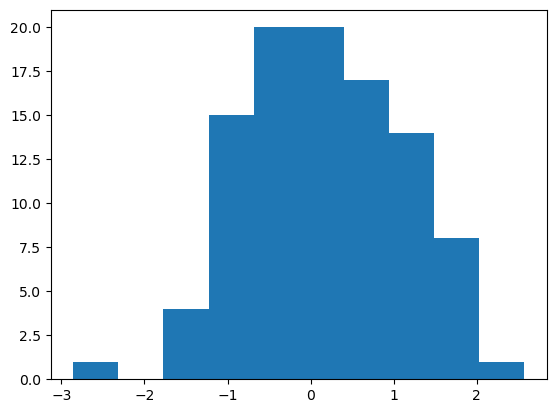

([1.0, 0.0, 4.0, 15.0, 20.0, 20.0, 17.0, 14.0, 8.0, 1.0], [-2.8570588615376273, -2.3144068535370845, -1.7717548455365422, -1.2291028375359996, -0.686450829535457, -0.1437988215349142, 0.3988531864656282, 0.9415051944661705, 1.4841572024667133, 2.026809210467256, 2.569461218467798], (PyObject <matplotlib.patches.Rectangle object at 0x28279fe50>, PyObject <matplotlib.patches.Rectangle object at 0x28279fca0>, PyObject <matplotlib.patches.Rectangle object at 0x2827c82b0>, PyObject <matplotlib.patches.Rectangle object at 0x2827c84f0>, PyObject <matplotlib.patches.Rectangle object at 0x2827c86d0>, PyObject <matplotlib.patches.Rectangle object at 0x2827c88b0>, PyObject <matplotlib.patches.Rectangle object at 0x2827c8a90>, PyObject <matplotlib.patches.Rectangle object at 0x2827c8c70>, PyObject <matplotlib.patches.Rectangle object at 0x2827c8e50>, PyObject <matplotlib.patches.Rectangle object at 0x2827c9030>))

In [86]:
hist(data)

In [93]:
chain = psample(model, RWMH(init_params), 100000, 4; param_names=["μ","σ"], chain_type=Chains)

LoadError: UndefVarError: psample not defined

In [88]:
init_params=ones(2)

2-element Vector{Float64}:
 1.0
 1.0

In [92]:
using Pkg
Pkg.add("AbstractMCMC")
using AbstractMCMC

   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [80f14c24] + AbstractMCMC v4.4.0
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [94]:
?LogDensityProblemsAD

search: LogDensityProblemsAD LogDensityProblems



Automatic differentiation backends for LogDensityProblems.


In [95]:
?LogDensityProblems

search: LogDensityProblems LogDensityProblemsAD



A unified interface for log density problems, for

1. defining mappings to a log density (eg Bayesian for inference),
2. optionally obtaining a gradient using automatic differentiation,
3. defining a common interface for working with such log densities and gradients (eg MCMC).

These use cases utilize different parts of this package, make sure you read the documentation.


In [122]:
X_bar

8×1 Matrix{Float64}:
 0.6483565433127019
 0.647910676617902
 0.6273077544435656
 0.6478926462889346
 0.6505437104220909
 0.6353471420662554
 0.6483217215407353
 0.63814507171178

In [126]:
a = [2.5, 3, -1, 3]

4-element Vector{Float64}:
  2.5
  3.0
 -1.0
  3.0

In [157]:
function logpi(α, nn, X_min, X_max, Y_target, sigma_hat; nu=1, alpha=0.01, alpha_b=3, beta_b=3)
    
    Y_pred = 10 .^ nn(α, true)
    r = Y_pred .- Y_target
    t = r ./ sigma_hat

    # StudentT distribution
    loglikelihood = sum(
        loggamma((nu + 1) / 2)
        - loggamma(nu / 2)
        .- log.(sqrt.(pi * nu) .* sigma_hat)
        .- (nu + 1) / 2.0 * log.(1 .+ 1.0 / nu .* t .^ 2)
    )
    # Beta prior
    X_bar = (α .- X_min) ./ (X_max - X_min)
    logprior = sum(
        (alpha_b - 1) * log.(X_bar) + (beta_b - 1) * log.(1 .- X_bar)
        .+ loggamma(alpha_b + beta_b) 
        .- loggamma(alpha_b)
        .- loggamma(beta_b)
    )

    insupport(X) = sum(X_bar .< 0) == 0
    insupport(X) ?  (alpha * loglikelihood + logprior) : -Inf
    
end

logpi (generic function with 2 methods)

In [151]:
function bar(X, X_min, X_max)
    (X .- X_min) ./ (X_max .- X_min)
end

insupport(X) = sum(bar(X, X_min, X_max) .< 0) == 0
density(X) = insupport(X) ? logpi(X, model, X_min, X_max, Y_target, sigma_hat) : -Inf

density (generic function with 1 method)

In [158]:
logpi(X_0, model, X_min, X_max, Y_target, sigma_hat)

-1451.7018975352285

In [153]:
# Construct a DensityModel.
dmodel = DensityModel(density)

# Set up the sampler with a multivariate Gaussian proposal.
H = Flux.hessian(logpi)
σ² = 1 / H
spl = MALA(x -> MvNormal((σ² / 2) .* x, σ² * I))

# Sample from the posterior.
chain = sample(dmodel, spl, 100000; init_params=X_0, chain_type=StructArray)

LoadError: MethodError: no method matching hessian(::typeof(logpi))
[0mClosest candidates are:
[0m  hessian(::Any, [91m::Any[39m) at ~/.julia/packages/Zygote/g2w9o/src/lib/grad.jl:62

In [154]:
using Flux

In [156]:
?Flux.hessian

```
hessian(f, x)
```

Construct the Hessian `∂²f/∂x²`, where `x` is a real number or an array, and `f(x)` is a real number. When `x` is an array, the result is a matrix `H[i,j] = ∂²f/∂x[i]∂x[j]`, using linear indexing `x[i]` even if the argument is higher-dimensional.

This uses forward over reverse, ForwardDiff over Zygote, calling `hessian_dual(f, x)`. See [`hessian_reverse`](@ref) for an all-Zygote alternative.

See also [`diaghessian`](@ref) to compute only the diagonal part.

# Examples

```jldoctest; setup=:(using Zygote)
julia> hessian(x -> x[1]*x[2], randn(2))
2×2 Matrix{Float64}:
 0.0  1.0
 1.0  0.0

julia> hessian(x -> sum(x.^3), [1 2; 3 4])  # uses linear indexing of x
4×4 Matrix{Int64}:
 6   0   0   0
 0  18   0   0
 0   0  12   0
 0   0   0  24

julia> hessian(sin, pi/2)
-1.0
```
